In [40]:
!pip install pytorch-ignite
!pip install torchsummary
!pip install tqdm

In [1]:
import torch
import torchvision
# The torchvision package consists of common image transformations,model architectures,etc.
import ignite 
# library to help with training and evaluating neural networks in PyTorch flexibly
print(*map(lambda m: ": ".join((m.__name__, m.__version__)), (torch, torchvision, ignite)), sep="\n")

torch: 1.11.0
torchvision: 0.12.0
ignite: 0.4.8


In [2]:
ignite.distributed.utils.device()

device(type='cuda')

In [3]:
import os
import logging
import matplotlib.pyplot as plt

import numpy as np

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist

import torchvision.utils as vutils

In [4]:
#To reproduce errors
ignite.utils.manual_seed(999)

In [5]:
#To import dataset. 
from torchvision.datasets import ImageFolder

In [6]:
import torch.utils.data
import torchvision.datasets as dset

In [7]:
#transforming image to fit the architecture
image_size = 64
#loading the dataset
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
train_dataset = dset.CIFAR10(root="./data", download=True,
                           transform=transform)
test_dataset = torch.utils.data.Subset(train_dataset,torch.arange(3000))


# Normalize does the following for each channel:

# image = (image - mean) / std

# The parameters mean, std are passed as 0.5, 0.5 in our case. This will normalize the image in the range [-1,1]. For example, 
# the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to (1-0.5)/0.5=1.

# to get our image back in [0,1] range, we could use,
# image = ((image * std) + mean)


nc=3

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                         shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


In [8]:
batch_size = 128

train_dataloader = idist.auto_dataloader(
    train_dataset, 
    batch_size=batch_size, 
    num_workers=2, #denotes the number of processes that generate batches in parallel
    shuffle=True, 
    drop_last=True,
)

test_dataloader = idist.auto_dataloader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=False, 
    drop_last=True,
)

2022-04-29 15:57:34,539 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Dataset CIFAR10': 
	{'batch_size': 128, 'num_workers': 2, 'shuffle': True, 'drop_last': True, 'pin_memory': True}
2022-04-29 15:57:34,542 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<torch.utils.data.da': 
	{'batch_size': 128, 'num_workers': 2, 'shuffle': False, 'drop_last': True, 'pin_memory': True}


In [ ]:
real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:80], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [9]:
latent_dim = 100

In [10]:
class Generator3x64x64(nn.Module):
    def __init__(self, latent_dim):
        super(Generator3x64x64, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # final state size. 3 x 64 x 64
            

#             transpose convolution is inverse of convolution,
#             for convolution, output=(input-kernel size+2*padding)/(stride) +1
#             => inverse is given as : output=stride*(input-1)+kernel size-2*pading
#             example calculation:
#             for input channel 256 x 8 x 8; kernel size=4, stride=2, padding=1
#             output=2*(8-1)+4-2*1 = 2*8-2+2=16
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [11]:
# auto_model is helper to simplify the code of distributed configuration setup. ex sending model to current device
netG = idist.auto_model(Generator3x64x64(latent_dim))

In [12]:
idist.device()
#  the model is automatically moved to the best device detected by idist

device(type='cuda')

In [13]:
summary(netG, (latent_dim, 1, 1))
#Generator summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [14]:
class Discriminator3x64x64(nn.Module):
    def __init__(self):
        super(Discriminator3x64x64, self).__init__()
        self.model = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [15]:
netD = idist.auto_model(Discriminator3x64x64())
summary(netD, (3, 64, 64))
#Discriminator summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

In [16]:
criterion = nn.BCELoss()
#Binary cross entropy loss function is used as given in paper
# loss=-[yn log xn + (1-yn)log(1-xn)]

In [17]:
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=idist.device())
# A batch of 64 fixed samples for generating images throughout the training

In [18]:
# two separate ADAM optimizers are set up, one for the generator, and one for the discriminator.
# method auto_optim provided by idist will help to adapt optimizer for distributed configurations.
optimizerD = idist.auto_optim(
    optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

optimizerG = idist.auto_optim(
    optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

In [19]:
real_label = 1
fake_label = 0

# Training in Ignite is based on three core components, namely, Engine, Events and Handlers
# The Engine can be considered somewhat similar to a training loop. 
# It takes a train_step as an argument and runs it over each batch of the dataset, triggering events as it goes.

# Events are emitted by the Engine when it reaches a specific point in the run/training

# Handlers are Functions that can be triggered when a certain Event is emitted by the Engine. 
# Ignite has a long list of pre defined Handlers such as checkpoint, early stopping, logging and built-in metrics

# A training step function will be run batch wise over the entire dataset by the engine. 
# It contains the basic training steps, namely, running the model, propagating the loss backward and taking an optimizer step. 
# We run the discriminator model on both real images and fake images generated by the Generator model. 
# The function returns Generator and Discriminator Losses and the output generated by Generator and Discriminator.


def training_step(engine, data):
    # Set the models for training
    netG.train()
    netD.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad() #Sets gradients to zero.
    # Format batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())
    # Forward pass real batch through D
    output1 = netD(real).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output1, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, latent_dim, 1, 1, device=idist.device())
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output2 = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output2, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output3 = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output3, label)
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }

In [20]:
trainer = Engine(training_step) #A PyTorch-Ignite engine trainer is defined using the above training_step function.

In [21]:
# Like the DCGAN paper, we randomly initialize all the model weights from a Normal Distribution with mean=0, stdev=0.02
def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [22]:
# The following init_weights handler is triggered at the start of the engine run
@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)

In [23]:
G_losses = []
D_losses = []
# The store_losses handler is responsible for storing the generator and discriminator losses 
# in G_losses and D_losses respectively. 
# It is triggered at the end of every iteration.

@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])

In [24]:
# The store_images handler is responsible for storing the images generated by the generator model during training. 
# It provides us with a visual progress of the training. It is triggered every 500 iterations.
img_list = []


@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    i=0
    with torch.no_grad():
        print("saving output")
        vutils.save_image(real,'output/real_image_%03d.png' %(i),normalize=True)
        fake = netG(fixed_noise).cpu()
        vutils.save_image(fake,'output/fake_image_%03d.png' %(i),normalize=True)
        i=i+1
    img_list.append(fake)

In [25]:
from ignite.metrics import FID
# Frechet Inception Distance (FID) is a metric that calculates the distance between 
# feature vectors calculated for real and generated images. It uses a pre-trained Inceptionv3 model. 
# It uses the mean and covariance between the real and generated images' feature vectors to measure performance of a GAN.

In [26]:
fid_metric = FID(device=idist.device())

In [27]:
# We define the function evaluation_step for the evaluation engine. 
# Our dataset provides 64 x 64 x 3 images but both IS and FID metrics use the Inceptionv3 model for 
# evaluation which requires images of minimum size 299 x 299 x 3, so the images 
# from the dataset and the images generated by the generator model must be interpolated
import PIL.Image as Image
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=idist.device())
        netG.eval()
        fake_batch = netG(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

In [28]:
# The train_evaluator engine will run the metric on the entire dataset every epoch and attach FID metrics to it
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")

In [29]:
fid_values = []

# The following handler attached to the trainer engine triggered every epoch will run 
# the train_evaluator engine to evaluate FID metrics. 
# The results are finally stored per epoch.

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    fid_values.append(fid_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*   FID : {fid_score:4f}")

In [30]:
# The RunningAverage metric is used to keep track of the generator and discriminator Losses
# RunningAverage keeps the track of average of all the values provided to it.

from ignite.metrics import RunningAverage


RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

In [31]:
#Progress bar utility handler that prevent all the training data from filling up screen
from ignite.contrib.handlers import ProgressBar


ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)

In [32]:
# the trainer engine is run here. 
# The helper method Parallel of idist will help setting up a distributed configuration to run the trainer engine

def training(*args):
    trainer.run(train_dataloader, max_epochs=5)

In [33]:
with idist.Parallel(backend='gloo') as parallel:
    parallel.run(training)

2022-04-29 15:59:10,567 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'gloo'
2022-04-29 15:59:10,568 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x0000029E882EB820>' in 1 processes


[1/390]   0%|           [00:00<?]

Current run is terminating due to exception: CUDA out of memory. Tried to allocate 348.00 MiB (GPU 0; 2.00 GiB total capacity; 827.81 MiB already allocated; 0 bytes free; 1.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Engine run is terminating due to exception: CUDA out of memory. Tried to allocate 348.00 MiB (GPU 0; 2.00 GiB total capacity; 827.81 MiB already allocated; 0 bytes free; 1.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Engine run is terminating due to exception: CUDA out of memory. Tried to allocate 348.00 MiB (GPU 0; 2.00 GiB total capacity; 827.81 MiB already allocated; 0 bytes free; 1.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory 

RuntimeError: CUDA out of memory. Tried to allocate 348.00 MiB (GPU 0; 2.00 GiB total capacity; 827.81 MiB already allocated; 0 bytes free; 1.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

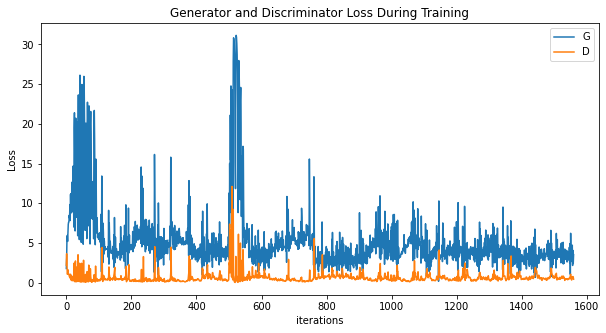

In [39]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

No handles with labels found to put in legend.


(0.0, 500.0)

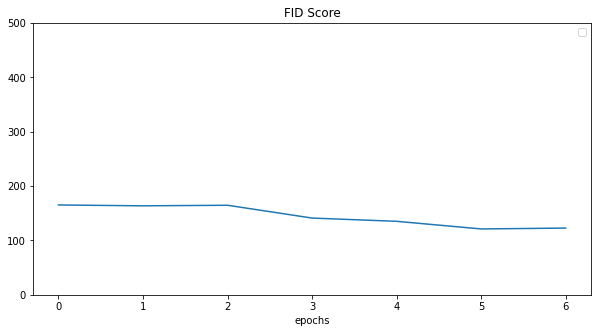

In [71]:
plt.figure(figsize=(10,5))
plt.title("FID Score")
plt.plot(fid_values)
plt.xlabel("epochs")
plt.legend()
plt.ylim([0, 500])

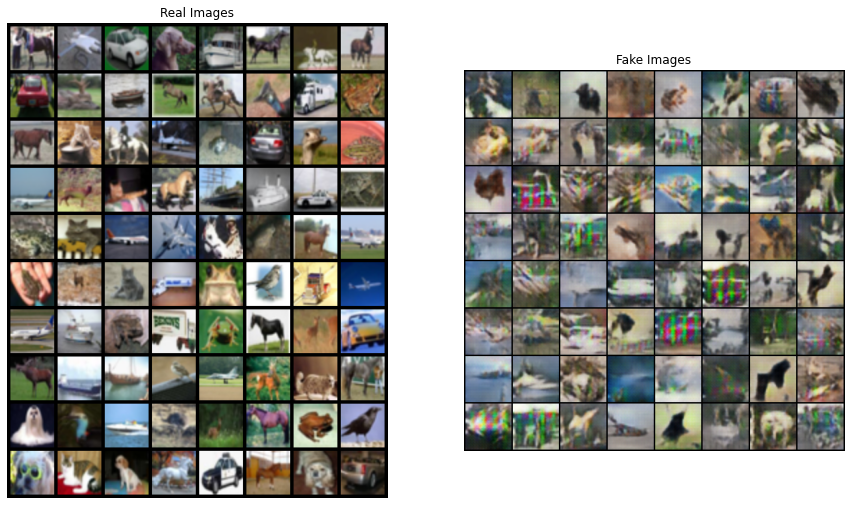

In [ ]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:80], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))